In [1]:
import sys
sys.path.append("../lib")
import os

import tensorflow as tf
from tensorflow.keras.utils import plot_model
import pickle
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

In [2]:
%matplotlib inline

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


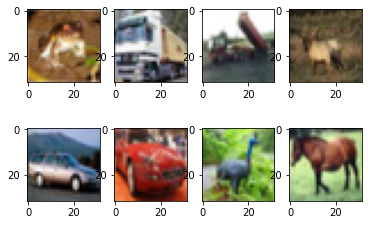

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [11]:
start = time.process_time()

# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]

    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    
    i += 1

In [12]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 

clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

In [13]:
end = time.process_time() - start

print("The trainging time of baseline model is ",end)

The trainging time of baseline model is  22.859375


For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [20]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    
    
    return clf.predict(feature)

### 2.2. Model I

For model I, we initially came up with three models including one ANN and two CNN models (with different architectures). After comparing the result of those models based on accuracy and computational time, we decided to apply a convolutional neural network (CNN) model as below, where CNN is a common Deep Learning algorithm used for analyzing visual imagery that extracts the feature of images and converts it into lower dimension without losing its characteristics.

We are still treating the noisy labels as clean ones.The model improves significantly in terms of prediction accuracy compared to the baseline logistic regression model.

- **Data Preparation**

In the whole dataset, we have 50000 images with noisy labels, and the first 10000 of them also have clean labels. We split the dataset in such a way that in the training set, we have 48000 images with noisy labels, and in the testing dataset, we have 2000 images with clean labels.

- **Model Building**

We build a multi-layer network, stacking up each layer by adding them one by one. There are several types of layers included and are constructed as follows: the convolutional layer is our first layer and the core building block of CNN, and the Leaky ReLU activation function which helps the network learn non-linear decision boundaries and fix the problem of dying Rectified Linear Units (ReLUs) is added; The max-pooling layer is used after the convolutional layer to reduce the spatial size (only width and height, not depth); repeat the above structure three times, and then use the Flattening layer to convert the multi-dimensional output into a one-dimensional tensor; the last layer of CNN is Dense layer along with a softmax activation function.

We choose Adam optimizer for gradient calculation and weight optimization. It provides an optimization algorithm that is computationally efficient and has little memory requirement to handle sparse gradients on noisy problems. Then we train the model with the data stated previously.

*Reference: Convolutional Neural Networks in Python with Keras (https://www.datacamp.com/community/tutorials/convolutional-neural-networks-python)*

In [3]:
from model_1 import model_1, train_model_1

In [29]:
# Model I should be pretrained: load from '../output/' if possible
if "model_1" in os.listdir("../output/"):
    mod_1 = tf.keras.models.load_model("../output/model_1")
else:
    train_model_1()
    mod_1 = tf.keras.models.load_model("../output/model_1")
model_1_res = pickle.load(open("../output/model_1_train_history", "rb"))

Source code of model_1

In [30]:
mod_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                        

- **Results**

The model shows the accuracy of the validation set is about 0.62. Compared with the accuracy of the training set, which is 0.27, the model is not overfitted. The baseline model we have, logistic regression, has the accuracy of 0.24. CNN model gives a better prediction than baseline model.

We also draw two plots: epoch-validation accuracy and epoch-loss change. We can see from the plots that when epoch is larger than 10, validation accuracy doesn't change much and neither does the percentage change. The total running time of the model is 2161.3 seconds.

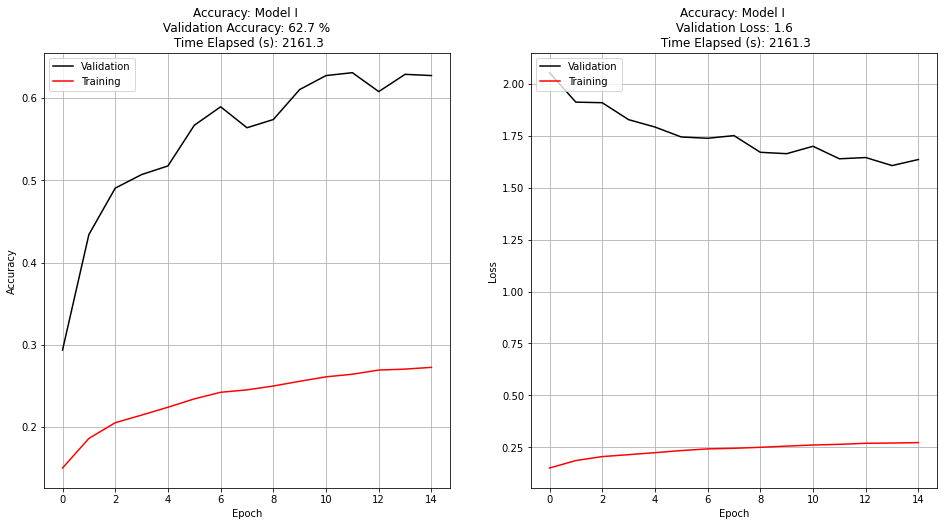

In [31]:
# Report training results

fig, ax = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

# Plot accuracy
ax[0].plot(model_1_res["val_accuracy"], "k", label="Validation")
ax[0].plot(model_1_res["accuracy"], "r", label="Training")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy: Model I \n Validation Accuracy: {:.1f} % \n Time Elapsed (s): {:.1f}".format(
    model_1_res["val_accuracy"][-1] * 100,
    model_1_res["time (s)"]
))
ax[0].grid()
ax[0].legend(loc="upper left")

ax[1].plot(model_1_res["val_loss"], "k", label="Validation")
ax[1].plot(model_1_res["accuracy"], "r", label="Training")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Accuracy: Model I \n Validation Loss: {:.1f} \n Time Elapsed (s): {:.1f}".format(
    model_1_res["val_loss"][-1],
    model_1_res["time (s)"]
))
ax[1].grid()
ax[1].legend(loc="upper left")

plt.show()

In [38]:
"""
Our source code for model_1 is nested under '../lib/model_1.py'. model_1 uses a deep CNN to first extract
contrast, rotational, textural features from the images directly. Then, the mapped images are passed through
a series of linear layers featuring ReLu activation and dropout.
"""

def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = image / 255.0
    prediction_prob = mod_1.predict(np.array([image]))
    return np.argmax(prediction_prob)

### 2.3. Model II

For model II, we first train a neural network that maps the noisy labels to clean labels, conditional on the input image. Then we use this trained network to get predicted labels from the noisy labels and utilize the predicted labels to train our CNN model in Model I.

- **Step 1:** We build a two-branch neural network as a label classifier, where the CNN takes image and noisy labels as input, tries to find functions that understand relation between images, noisy labels and clean labels, and gives clean labels as output (y). 

- **Step 2:** We have labels cleaned by step 1 and we repeat the steps in model 1 prediction. 

In [8]:
from model_2 import label_classifier, model_1, train_model_2

In [33]:
# Model II should be pretrained: load from '../output/' if possible
if "model_2" in os.listdir("../output/"):
    label_classifier = tf.keras.models.load_model("../output/label_classifier")
    mod_2 = tf.keras.models.load_model("../output/model_2")
else:
    train_model_2()
    label_classifier = tf.keras.models.load_model("../output/label_classifier")
    mod_2 = tf.keras.models.load_model("../output/model_2")
model_2_res = pickle.load(open("../output/model_2_train_history", "rb"))
label_classifier_res = pickle.load(open("../output/label_classifier_train_history", "rb"))

Source code for label classifier. After label classifier is trained, data passes through label classifier and model I is retrained with predicted labels as the target.

In [10]:
label_classifier.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   896         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 16, 16, 32)   0           ['leaky_re_lu[0][0]']            
                                                                                            

- Results
The accuracy of the training set is about 0.67, and the accuracy of the validation set is about 0.66. The running time is 1628.1 seconds.

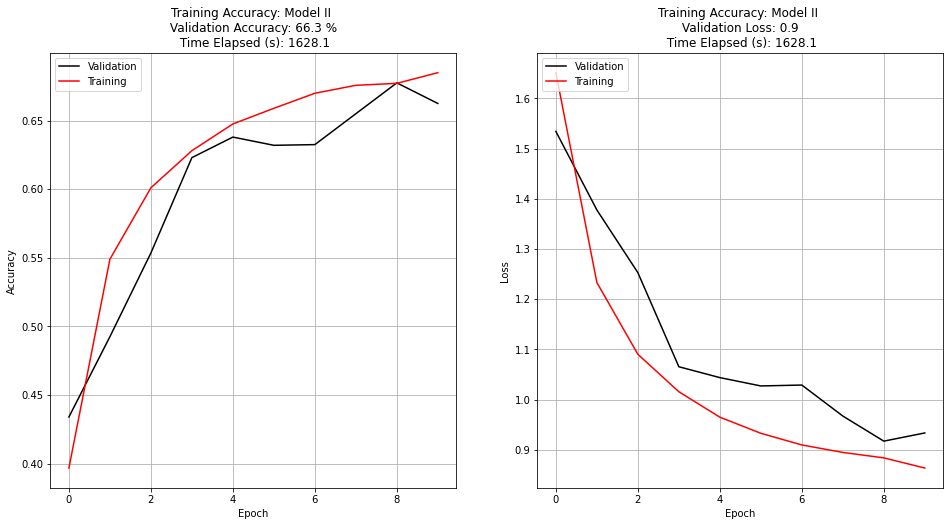

In [34]:
# Report training results

fig, ax = plt.subplots(figsize=(16, 8), nrows=1, ncols=2)

# Plot accuracy
ax[0].plot(model_2_res["val_accuracy"], "k", label="Validation")
ax[0].plot(model_2_res["accuracy"], "r", label="Training")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Training Accuracy: Model II \n Validation Accuracy: {:.1f} % \n Time Elapsed (s): {:.1f}".format(
    model_2_res["val_accuracy"][-1] * 100,
    model_2_res["time (s)"] + label_classifier_res["time (s)"]
))
ax[0].grid()
ax[0].legend(loc="upper left")

ax[1].plot(model_2_res["val_loss"], "k", label="Validation")
ax[1].plot(model_2_res["loss"], "r", label="Training")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Training Accuracy: Model II \n Validation Loss: {:.1f} \n Time Elapsed (s): {:.1f}".format(
    model_2_res["val_loss"][-1],
    model_2_res["time (s)"] + label_classifier_res["time (s)"]
))
ax[1].grid()
ax[1].legend(loc="upper left")

plt.show()

In [39]:
"""
Our source code for model_2 is nested under '../lib/model_2.py'. Specifically, model_2 trains
a two-branched CNN using images, noisy labels and clean labels as the target in the label_classifier() function.
Then, we train the CNN used in model_1 using images and predicted labels as target.
"""


def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = image / 255.0
    prediction_prob = mod_2.predict(np.array([image]))
    return np.argmax(prediction_prob)

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [9]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
# test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

error: OpenCV(4.5.4-dev) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

## Results to CSV

In [73]:
# Read test data
n_test = 10000
test_imgs = np.empty((n_test,32,32,3))
name_list = np.empty((n_test))

for i in range(0, n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    name_list[i] = f'{i+1:05d}'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)


def get_res(model,test_imgs):
    """Given set of images, returns predictions."""
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image)[0])
    return y_pred

In [74]:
res1 = get_res(baseline_model, test_imgs)

test_imgs = test_imgs / 255.0
res2 = np.argmax(mod_1.predict(test_imgs), axis=1)
res3 = np.argmax(mod_2.predict(test_imgs), axis=1)

results = {
    "Index":name_list,
    "Baseline": res1,
    "Model I": res2,
    "Model II": res3
}

results_df = pd.DataFrame(results)
results_df.to_csv("../output/label_prediction.csv")

In [ ]:
def get_test_acc(predicted_labels, true_labels):
    n_correct = 0
    for i in range(len(true_labels)):
        if predicted_labels[i] == true_labels[i]:
            n_correct += 1
    return n_correct / len(true_labels)
    
    
print("Baseline Test Accuracy: {}".format(get_test_acc_acc(res1, test_labels)))
print("Model I Test Accuracy: {}".format(get_test_acc_acc(res2, test_labels)))
print("Model II Test Accuracy: {}".format(get_test_acc_acc(res3, test_labels)))